# ML в Биологии
## 9. Gradient Boosting

In [35]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import time

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor, Pool

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils import shuffle

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, CatBoostClassifier

plt.rcParams['axes.facecolor'] = 'lightgrey'
sns.set(palette='Set2', font_scale=1.6)

### Применения градиентного бустинга.

Градиентный бустинг может быть применен в огромном множестве реальных задач.

Реальные задачи, где применяется бустинг:    

☣

[Бустинг в предсказании лекарств](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0209-z)

[Предсказание сайтов связывания белков с ДНК](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2527-1)

[Оценивание качества молекулярного докинга](https://pubmed.ncbi.nlm.nih.gov/30873528/)

[Бустинг и нейросети в задаче оценивания влияния вариаций в некодирующих регионах ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4768299/)

⚛

[Smuon collider analysis](https://arxiv.org/abs/2109.11815): применяется бустинг, PCA, отбор признаков.


[Бустинг и бозон Хиггса](http://proceedings.mlr.press/v42/chen14.pdf)

<!--
🏫

[Предсказание распределения студентов](https://www.researchgate.net/publication/338853863_STUDENT_PLACEMENT_PREDICTION_MODEL_USING_GRADIENT_BOOSTED_TREE_ALGORITHM)


[Моделирование индивидуального профиля студента](https://www.igi-global.com/article/student-profile-modeling-using-boosting-algorithms/284084) -->

### Задача 1

**Внимание!**

Не забудьте, что на тестовой выборке, по которой делаются итоговые выводы, ничего не должно обучаться.

*Совет. При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки оставшегося времени работы используйте tqdm в циклах.*

Для исследования вам предлагается несколько датасетов:

#### **Профиль биология:** [датасет](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure) про физикохимические свойства третичной структуры белков.

В этом датасете содержатся следующие признаки:
```
 RMSD-Size of the residue.
 F1 - Total surface area.
 F2 - Non polar exposed area.
 F3 - Fractional area of exposed non polar residue.
 F4 - Fractional area of exposed non polar part of residue.
 F5 - Molecular mass weighted exposed area.
 F6 - Average deviation from standard exposed area of residue.
 F7 - Euclidian distance.
 F8 - Secondary structure penalty.
 F9 - Spacial Distribution constraints (N,K Value).
```




Мы будем предсказывать размер остатка (RMSD) по остальным признакам.
Датасет был получен с помощью [CASP9](https://predictioncenter.org/CASP9/).




Скачать датасет можно с помощью `sklearn`:

In [36]:
from sklearn.datasets import fetch_openml

protein = fetch_openml(name='physicochemical-protein')
data = pd.DataFrame(protein.data, columns=protein.feature_names)
X, y = data.drop("RMSD", axis=1), data.RMSD

Этот датасет большой по размеру, так что можете взять в качестве данных его случайную половину.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

train_inds = np.random.choice(np.arange(y_train.shape[0]), y_train.shape[0]//2, replace=False)
sX_train, sy_train = np.array(X_train)[train_inds], np.array(y_train)[train_inds]

##### 1.

Повторите исследование, проведенное в предыдущем домашнем задании, используя градиентный бустинг из `sklearn`. Сравните полученные результаты со случайным лесом.

Вкратце опишем задания:
1. Посмотрите, как меняется качество модели в зависимости от значений гиперпараметров и сделайте выводы по результатам. Гиперпараметры:
    * количество деревьев (`n_estimators`) [от 1 до 400];
    * максимальная глубина дерева (`max_depth`) [от 3 до 15].
    * скорость обучения (`learning_rate`), поясните также смысл этого параметра.
2. Запустите модель три раза с параметрами по умолчанию. Объясните результаты.
3. Подберите оптимальные гиперпараметры, рассмотренные в первом пункте и зафиксируйте их.
4. Исследуйте зависимость метрики от количества признаков, по которым происходит разбиение в вершине дерева. Объясните результаты.
5. Исследуйте время работы фита и предикта, среднюю глубину деревьев и количество листьев в дереве.

*Замечания.*
* В качестве основы можно использовать свое решение предыдущего задания. В большинстве случаев нужно только заменить `RandomForestRegressor` на `GradientBoostingRegressor`/ или`GradientBoostingClassifierr`.
* При сравнении методов по одинаковым свойствам желательно рисовать результаты на одном графике.
* Обратите внимание на метод `staged_predict` у `GradientBoostingRegressor`. Он позволяет получить "кумулятивные" предсказания, то есть по первым $t$ деревьям по всем значениям $t.$
* При желании, границы рассмотрения значений гиперпараметров можно увеличить.
* При подборе гиперпараметров при помощи рандомизированного поиска проводите достаточное количество на большой сетке параметров &mdash; как минимум 50. Даже если долго обучается.
* Используйте `tqdm` для оценки времени выполнения кода.

### 1.1. Посмотрим, как меняется качество модели в зависимости от значений гиперпараметров и сделаем выводы по результатам.

In [38]:
boosting_mse_train = []
boosting_mse_test = []

n_estimators_grid = np.arange(1, 402, 40)

for n_estimators in tqdm(n_estimators_grid):
    gb = GradientBoostingRegressor(n_estimators=n_estimators)
    gb.fit(sX_train, sy_train)

    boosting_mse_train.append(mse(sy_train, gb.predict(sX_train)))
    boosting_mse_test.append(mse(y_test, gb.predict(X_test.values)))

  0%|          | 0/11 [00:00<?, ?it/s]

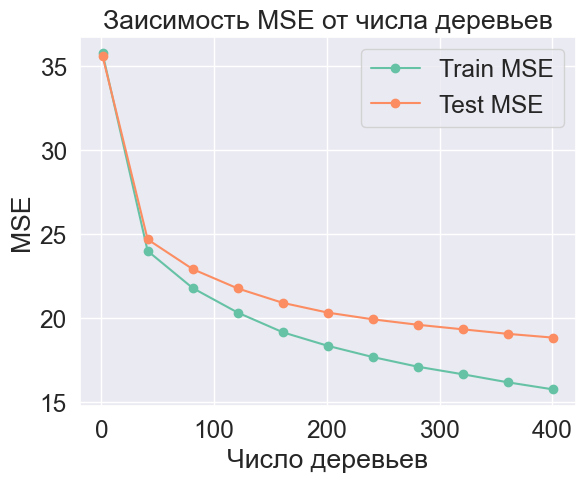

In [39]:
plt.plot(n_estimators_grid, boosting_mse_train, label='Train MSE', marker='o')
plt.plot(n_estimators_grid, boosting_mse_test, label='Test MSE', marker='o')

plt.title('Заисимость MSE от числа деревьев')
plt.xlabel('Число деревьев')
plt.ylabel('MSE')
plt.legend()

**Вывод:**

Наблюдаем, что с увеличением количества деревьев значение MSE уменьшается. Со временем ошибка на обучающей и тестовой выборках начинает расходиться, что указывает на небольшое переобучение модели. Тем не менее, как на обучающей, так и на тестовой выборках ошибка продолжает снижаться, что является положительным результатом.

In [40]:
depth_boosting_mse_train = []
depth_boosting_mse_test = []

max_depth_grid = np.arange(3, 16, 1)

for max_depth in tqdm(max_depth_grid):
    gb = GradientBoostingRegressor(max_depth=max_depth)
    gb.fit(sX_train, sy_train)

    depth_boosting_mse_train.append(mse(sy_train, gb.predict(sX_train)))
    depth_boosting_mse_test.append(mse(y_test, gb.predict(X_test.values)))

  0%|          | 0/13 [00:00<?, ?it/s]

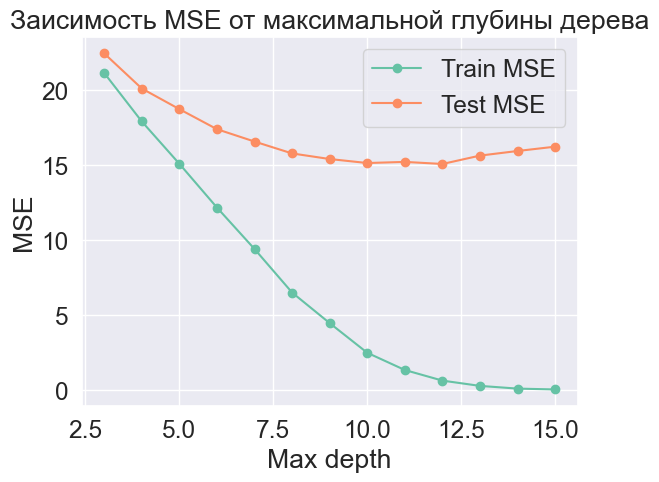

In [41]:
plt.plot(max_depth_grid, depth_boosting_mse_train, label='Train MSE', marker='o')
plt.plot(max_depth_grid, depth_boosting_mse_test, label='Test MSE', marker='o')

plt.title('Заисимость MSE от максимальной глубины дерева')
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.legend()

**Вывод:**

С увеличением максимальной глубины ошибка на обучающей выборке значительно снижается, в то время как ошибка на тестовой выборке сначала уменьшается, а затем начинает возрастать, что указывает на переобучение. Следовательно, слишком глубокие деревья оказываются нежелательными. Оптимальный диапазон значений max_depth составляет от 7 до 12.

In [42]:
lr_boosting_mse_train = []
lr_boosting_mse_test = []

lr_grid = np.linspace(0, 1, 11)

for lr in tqdm(lr_grid):
    gb = GradientBoostingRegressor(learning_rate=lr)
    gb.fit(sX_train, sy_train)

    lr_boosting_mse_train.append(mse(sy_train, gb.predict(sX_train)))
    lr_boosting_mse_test.append(mse(y_test, gb.predict(X_test.values)))

  0%|          | 0/11 [00:00<?, ?it/s]

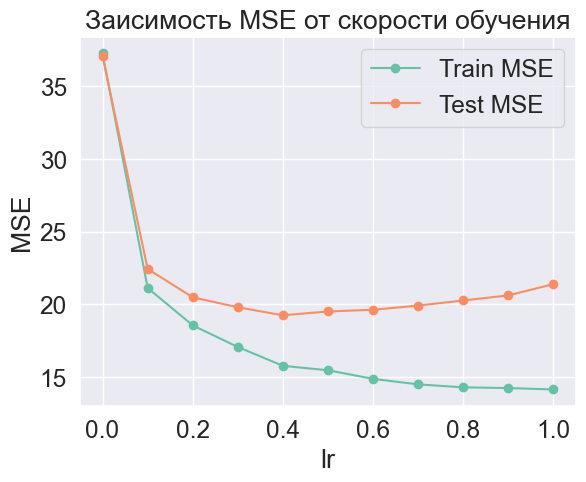

In [43]:
plt.plot(lr_grid, lr_boosting_mse_train, label='Train MSE', marker='o')
plt.plot(lr_grid, lr_boosting_mse_test, label='Test MSE', marker='o')

plt.title('Заисимость MSE от скорости обучения')
plt.xlabel('lr')
plt.ylabel('MSE')
plt.legend()

**Вывод:**

**Learning rate** — это коэффициент, с которым мы добавляем значение t-ой модели к общему предсказанию.

Можно заметить, что ошибка на обучающей выборке монотонно снижается с увеличением скорости обучения, тогда как на тестовой выборке она сначала уменьшается, а затем начинает расти, что свидетельствует о переобучении. Оптимальные значения скорости обучения находятся в диапазоне от 0.3 до 0.5.

### 1.2. Запуск модель три раза с параметрами по умолчанию.

In [44]:
results = []

for _ in range(3):
    gb = GradientBoostingRegressor()
    gb.fit(sX_train, sy_train)

    results.append(mse(y_test, gb.predict(X_test.values)))

results

[22.428074778149252, 22.429198355254172, 22.428562638354713]

**Выводы:**

Результаты практически не изменяются при перезапуске, что свидетельствует о низком уровне дисперсии у бустинга.

### 1.3. Подбор оптимальных гиперпараметров, рассмотренные в первом пункте и их фиксация.

In [45]:
params = {
    'n_estimators' : np.arange(200, 500, 10),
    'max_depth' : [5, 6, 7, 8, 9, 10, 11],
    'learning_rate' : np.linspace(0.01, 0.7, 20)
}

estimator = GradientBoostingRegressor()

clf = RandomizedSearchCV(estimator, params, n_iter=50, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')
clf.fit(sX_train, sy_train)

clf.best_params_

{'n_estimators': 490, 'max_depth': 10, 'learning_rate': 0.08263157894736842}

### 1.4. Исследование зависимости метрики от количества признаков, по которым происходит разбиение в вершине дерева.

In [46]:
max_features_boosting_mse_train = []
max_features_boosting_mse_test = []

max_features_grid = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]  # от 10% до 100% всех признаков

for max_features in tqdm(max_features_grid):
    gb = GradientBoostingRegressor(max_features=max_features, n_estimators = 490, max_depth = 10, learning_rate = 0.08263157894736842)
    gb.fit(sX_train, sy_train)

    max_features_boosting_mse_train.append(mse(sy_train, gb.predict(sX_train)))
    max_features_boosting_mse_test.append(mse(y_test, gb.predict(X_test.values)))

  0%|          | 0/6 [00:00<?, ?it/s]

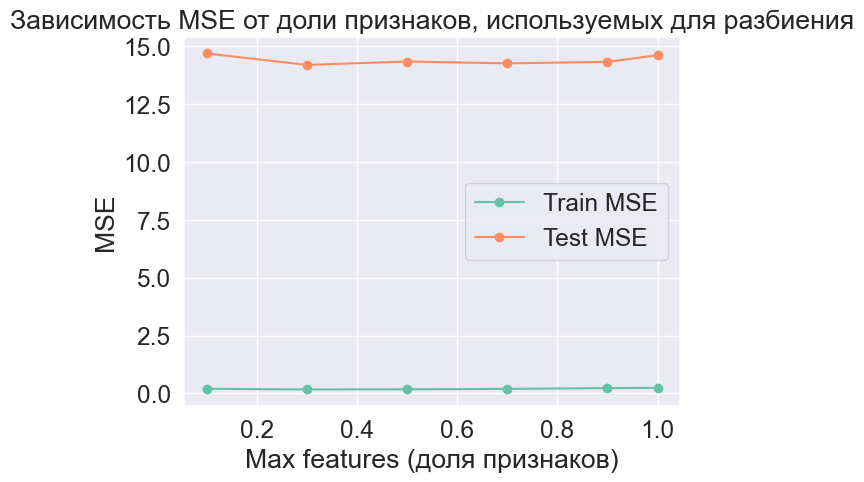

In [47]:
plt.plot(max_features_grid, max_features_boosting_mse_train, label='Train MSE', marker='o')
plt.plot(max_features_grid, max_features_boosting_mse_test, label='Test MSE', marker='o')

plt.title('Зависимость MSE от доли признаков, используемых для разбиения')
plt.xlabel('Max features (доля признаков)')
plt.ylabel('MSE')
plt.legend()

**Вывод:**

Пто по мере увеличения доли признаков (`max_features`) для разбиения в вершине дерева, ошибка на обучающем (`Train MSE`) и тестовом (`Test MSE`) наборах данных остается практически постоянной. Это говорит о том, что добавление большего количества признаков для выбора оптимального разбиения не оказывает значительного влияния на качество модели в данном слунпроизводительностью.

### 1.5. Исследование времени работы фита и предикта, средней глубины деревьев и количества листьев в дереве.

In [48]:
fit_times = []
predict_times = []
tree_depths = []
leaf_counts = []

gb = GradientBoostingRegressor(n_estimators=490, max_depth=10, learning_rate=0.08263157894736842)

# Измеряем время обучения
start_fit = time.time()
gb.fit(sX_train, sy_train)
fit_time = time.time() - start_fit

# Измеряем время предсказания
start_predict = time.time()
predictions = gb.predict(X_test.values)
predict_time = time.time() - start_predict

for tree in gb.estimators_:
    tree_depths.append(tree[0].get_depth())
    leaf_counts.append(tree[0].get_n_leaves())

# Средняя глубина деревьев и среднее количество листьев
avg_depth = np.mean(tree_depths)
avg_leaf_count = np.mean(leaf_counts)

fit_times.append(fit_time)
predict_times.append(predict_time)

print(f'Время обучения: {fit_time:.4f} секунд')
print(f'Время предсказания: {predict_time:.4f} секунд')
print(f'Средняя глубина деревьев: {avg_depth:.2f}')
print(f'Среднее количество листьев в деревьях: {avg_leaf_count:.2f}')

Время обучения: 87.0700 секунд
Время предсказания: 0.1270 секунд
Средняя глубина деревьев: 10.00
Среднее количество листьев в деревьях: 314.97


**Вывод:**

**Время обучения:**

Довольно велико, что может быть связано с тем, что ансамбль обучается на большом количестве данных или использует относительно глубокие деревья. Средняя глубина деревьев равна 10, что позволяет моделям захватывать достаточно сложные зависимости в данных.

**Время предсказания:**

Низкое (0.127 секунд), что делает модель эффективной для применения на практике.

**Средняя глубина деревьев и количество листьев:**

также указывают на то, что деревья имеют достаточно сложную структуру, позволяющую детально моделировать зависимости в данных.производительностью.

### 2.

Выберите самый значимый признак согласно `feature_importances_`. Визуализируйте работу бустинга, обученного только на одном этом признаке.

Для этого рассмотрите процесс построения бустинга для первых 10 итераций. При визуализации требуется для каждой итерации нарисовать:
* предсказания новой базовой модели и выборку, на которой эта базовая модель обучается;
* предсказания текущей композиции и исходную обучающую выборку.

Пример графиков смотрите в лекции в разделе бустинг в задаче регресии.

In [49]:
def plot_importance(model, columns, title=''):
    global_importances = pd.Series(model.feature_importances_, index=columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')

    plt.xlabel('Importance')
    plt.ylabel('Feature')

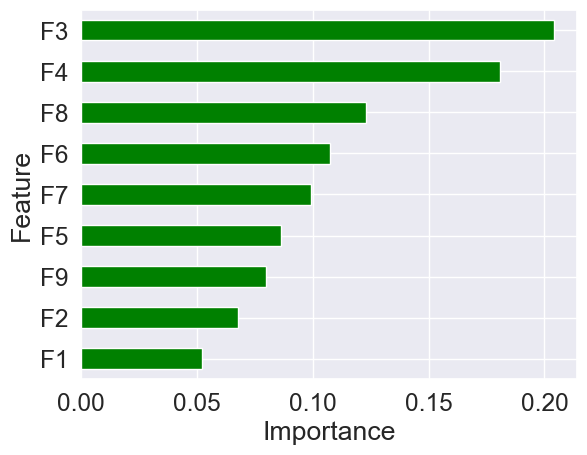

In [50]:
gb = GradientBoostingRegressor(n_estimators=490, max_depth=10, learning_rate=0.08263157894736842)
gb.fit(sX_train, sy_train)
plot_importance(gb, X_train.columns)

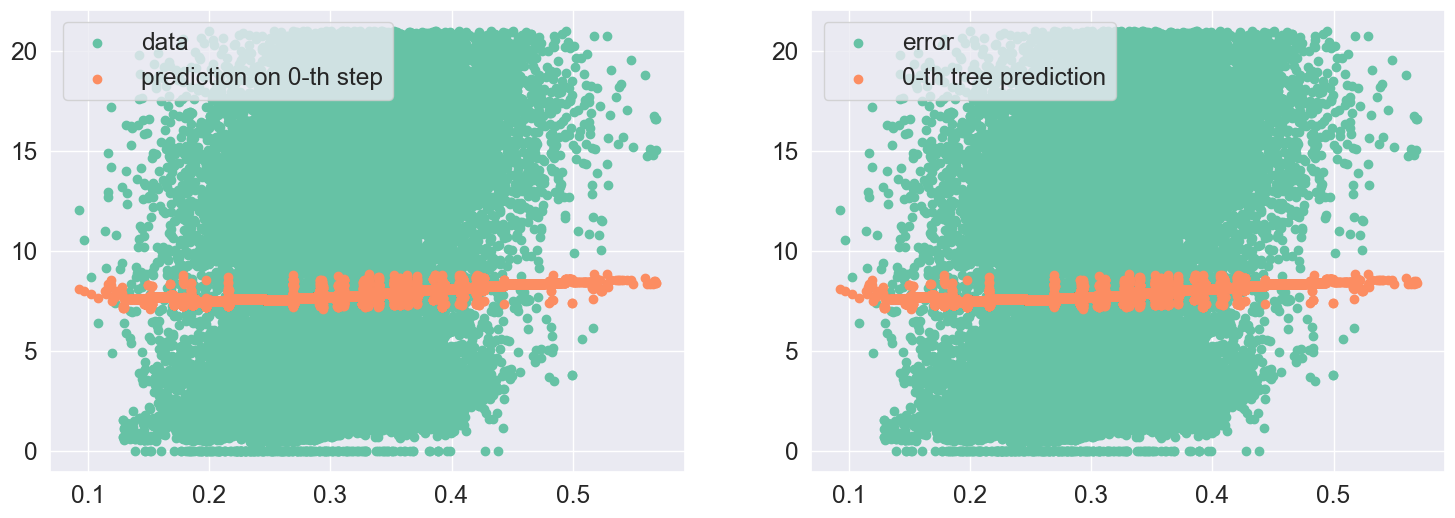

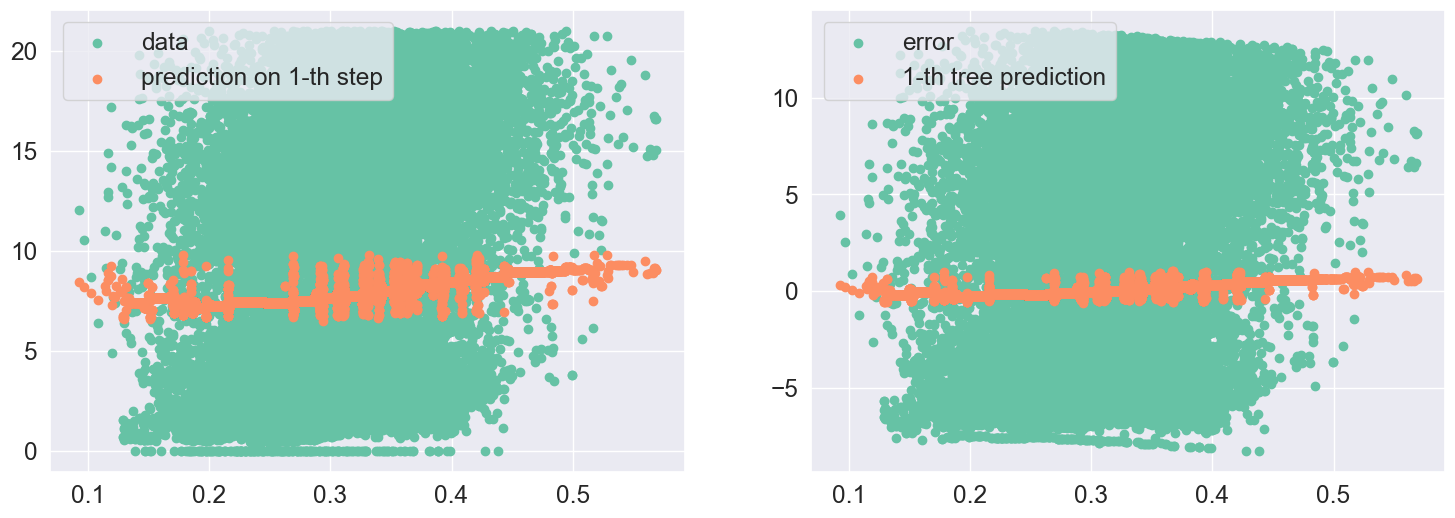

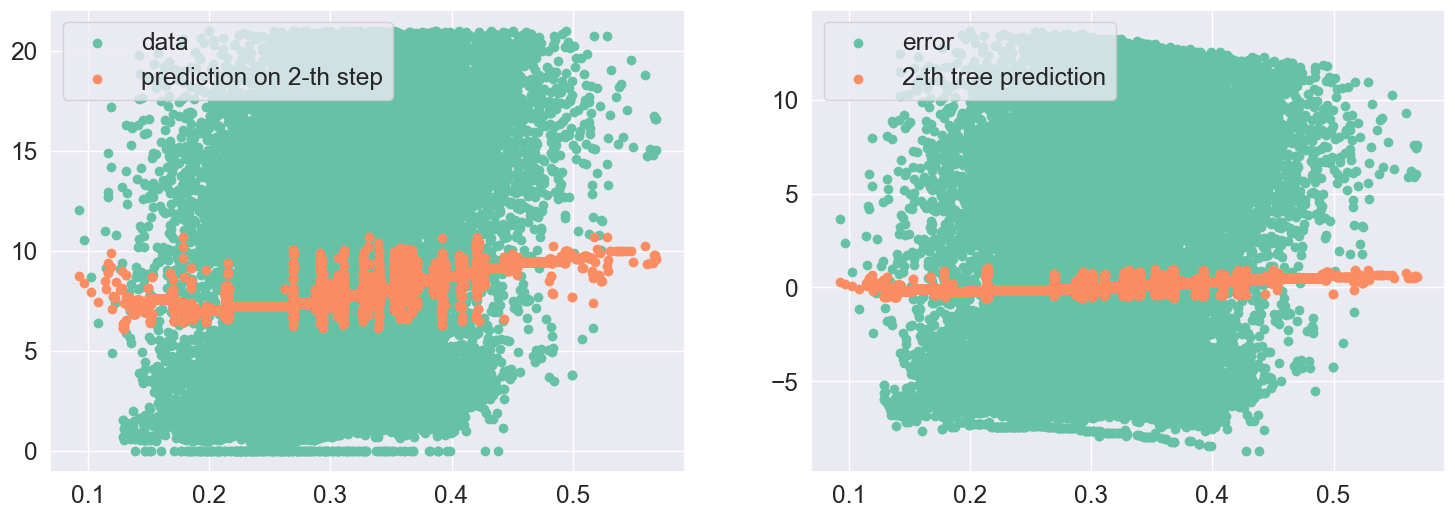

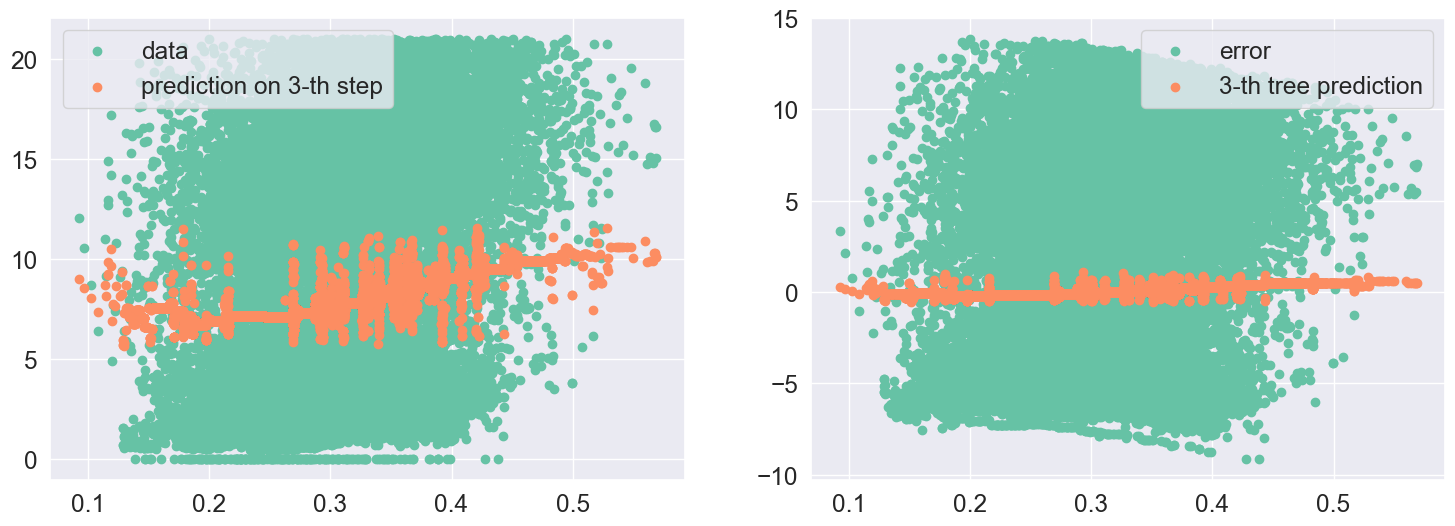

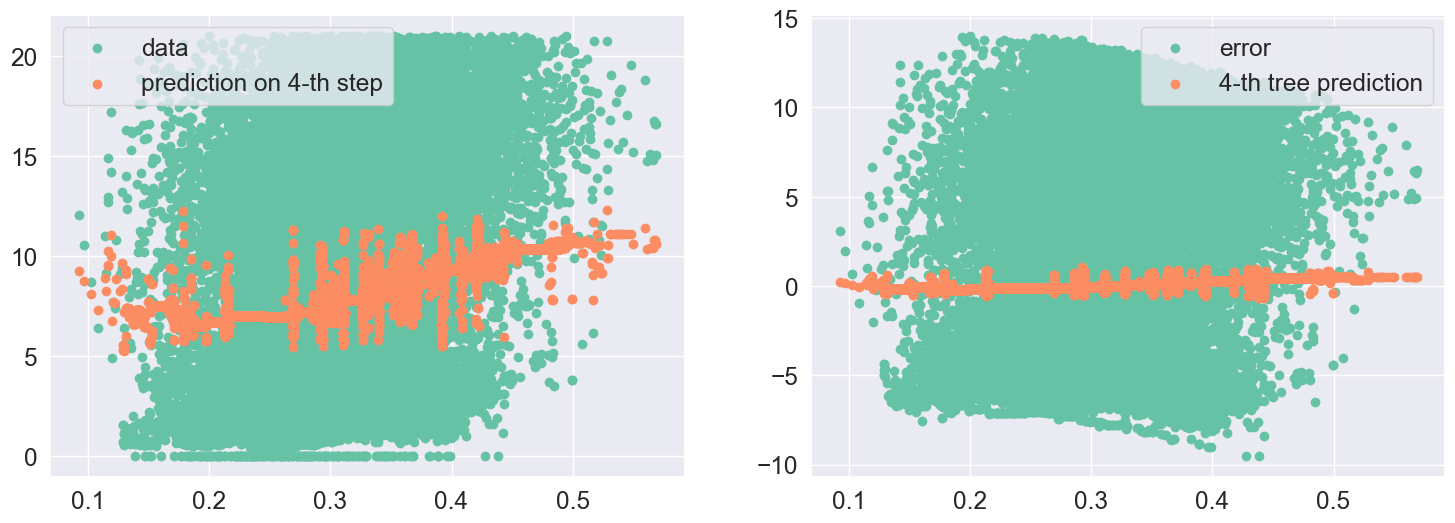

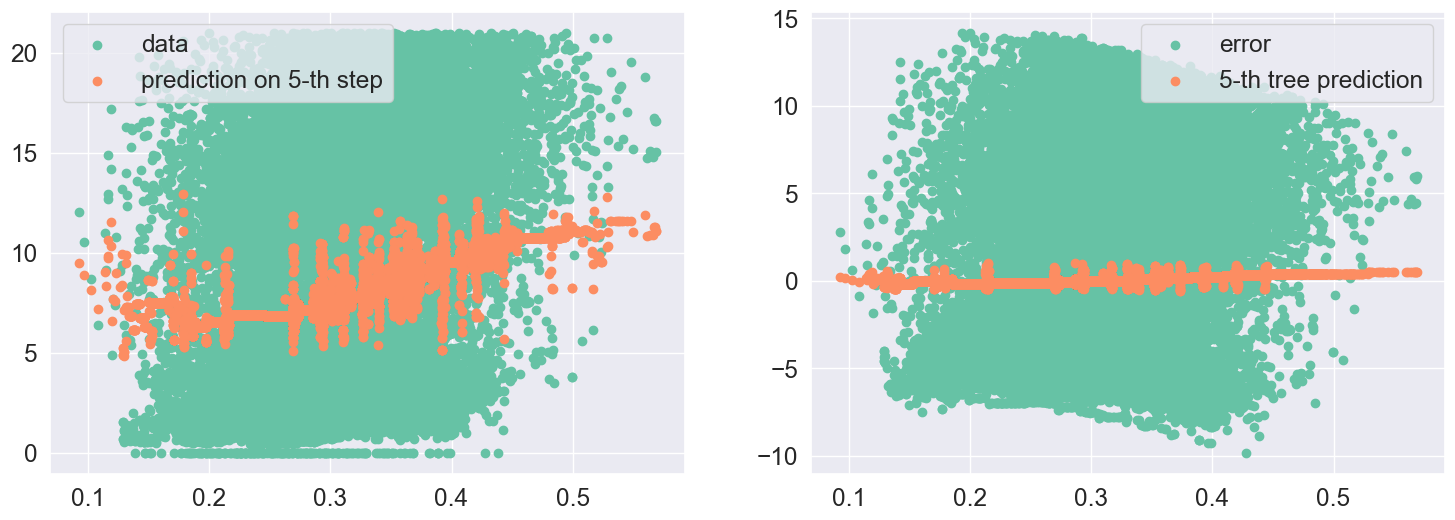

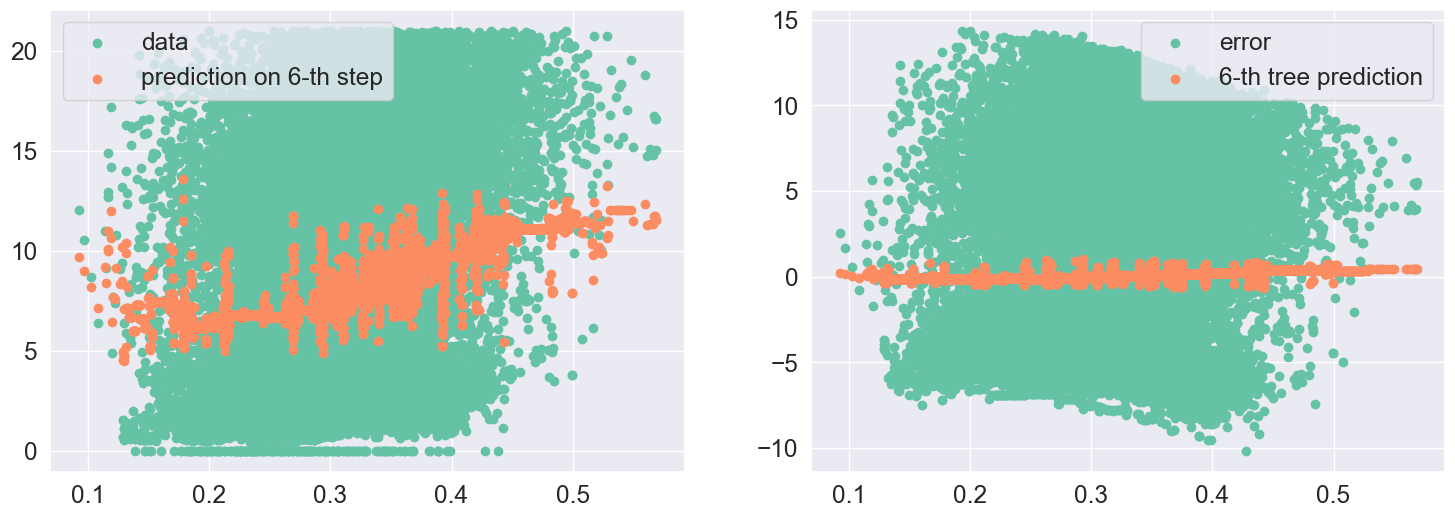

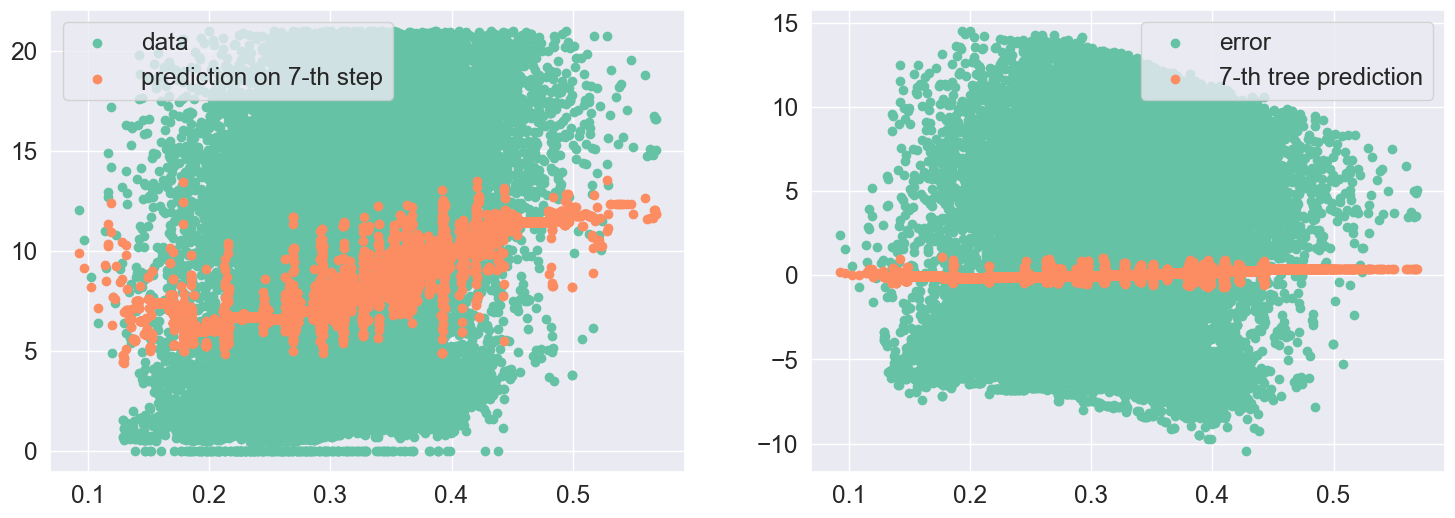

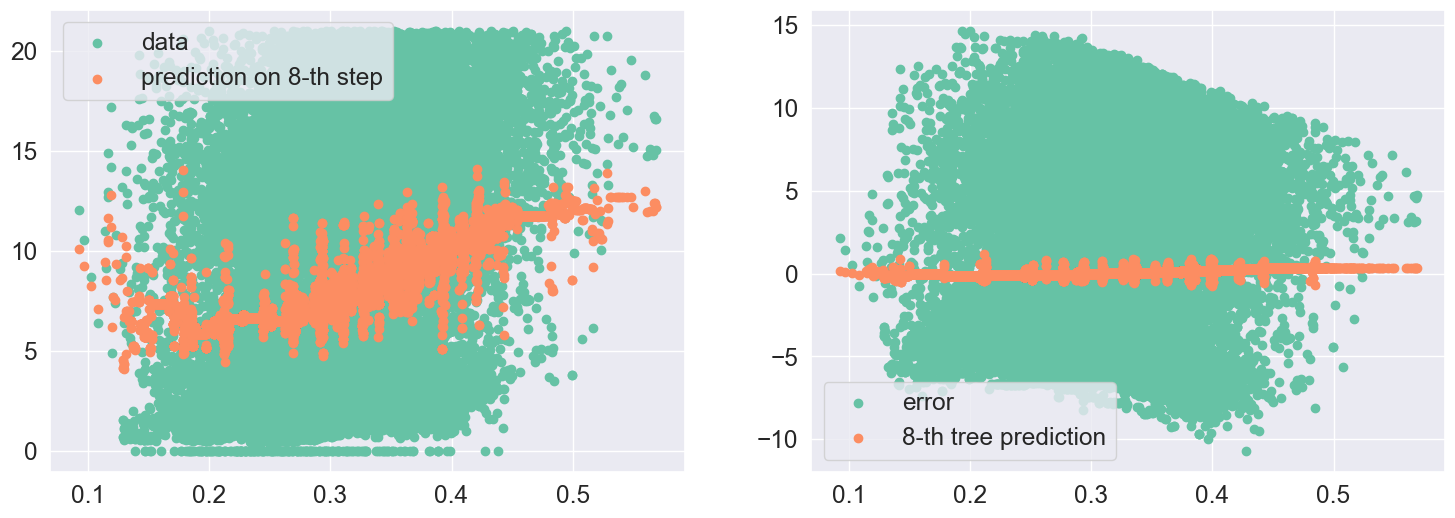

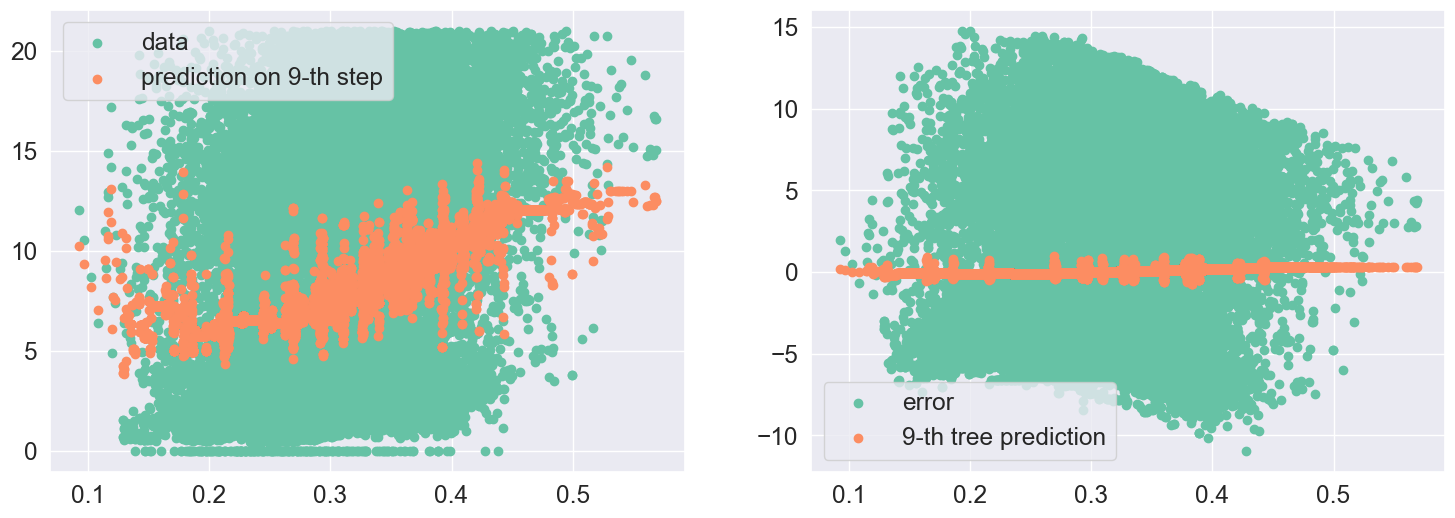

In [51]:
onef_X_train = np.array(X_train['F3']).reshape(-1, 1)

regressor = GradientBoostingRegressor(n_estimators=490, max_depth=10, learning_rate=0.08263157894736842)
regressor.fit(onef_X_train, y_train)

staged = list(regressor.staged_predict(onef_X_train))

for i in range(10):
    if i == 0:
        previous_predict = np.zeros(len(y_train))
    else:
        previous_predict = staged[i-1]
    error = y_train - previous_predict
    current_step_predict = staged[i] - previous_predict

    fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
    axs[0].scatter(onef_X_train, y_train, label='data')
    axs[0].scatter(onef_X_train, staged[i], label=f'prediction on {i}-th step')
    axs[0].legend()

    axs[1].scatter(onef_X_train, y_train - previous_predict, label='error')
    axs[1].scatter(onef_X_train, current_step_predict, label=f'{i}-th tree prediction')
    axs[1].legend()

**Выводы:**

Наблюдается, что с каждой итерацией "облако" точек ответов "расплывается" от линии y=0, охватывая правильные значения. Этот процесс идет медленно из-за низкой скорости обучения. Чтобы получить более значимые результаты, необходимо увеличить количество итераций. Это будет сделано в следующей ячейке.

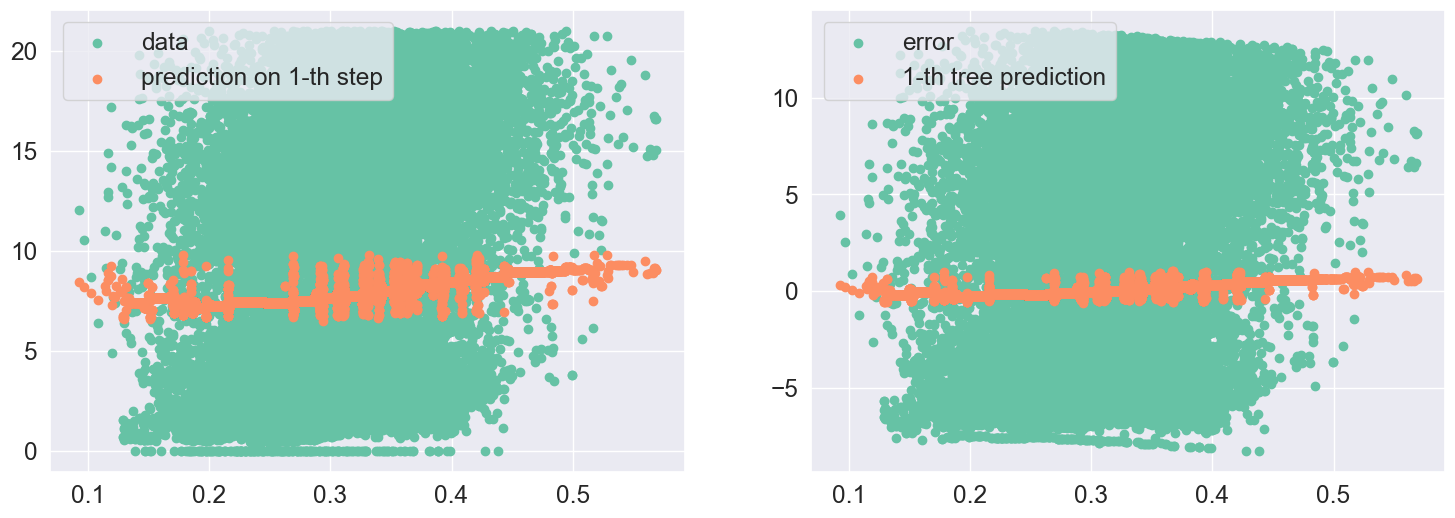

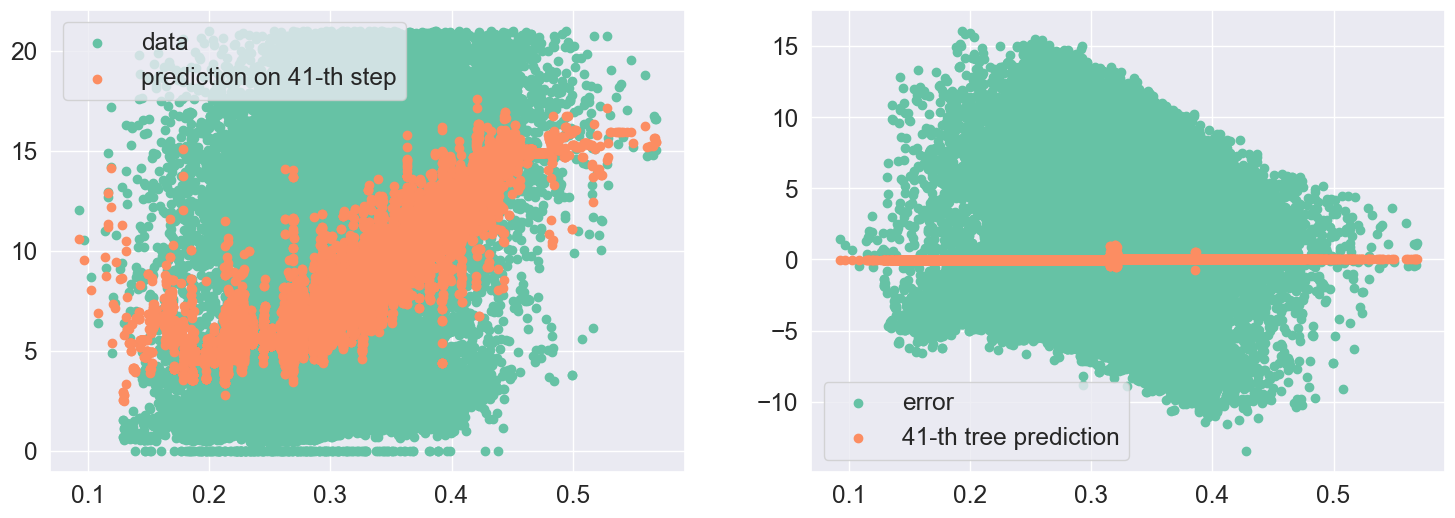

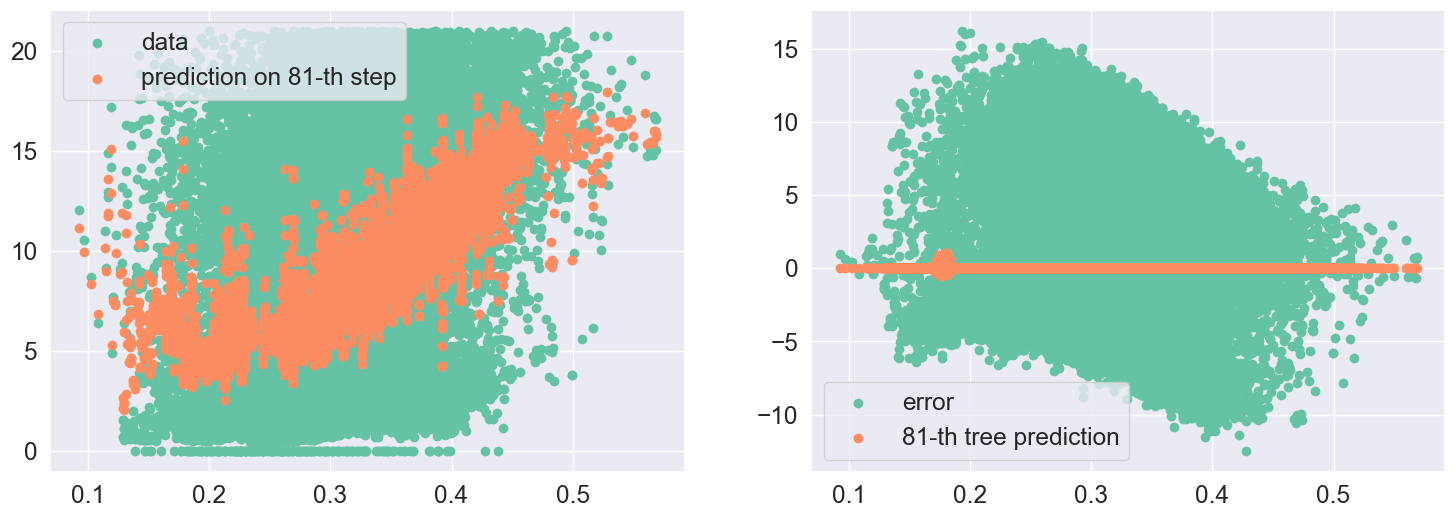

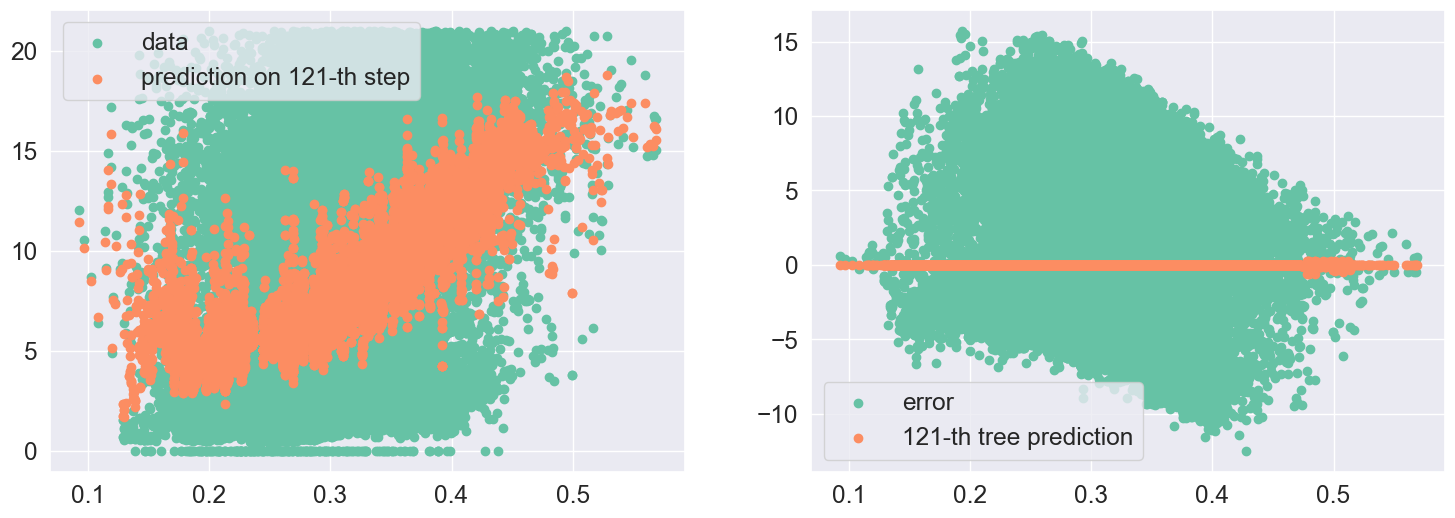

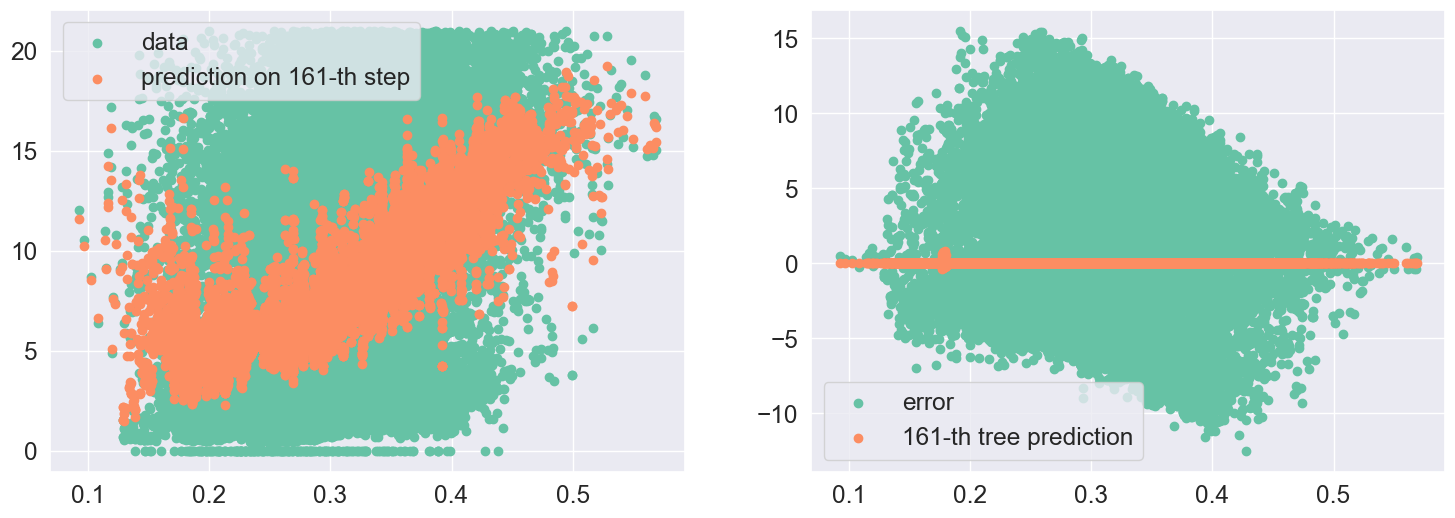

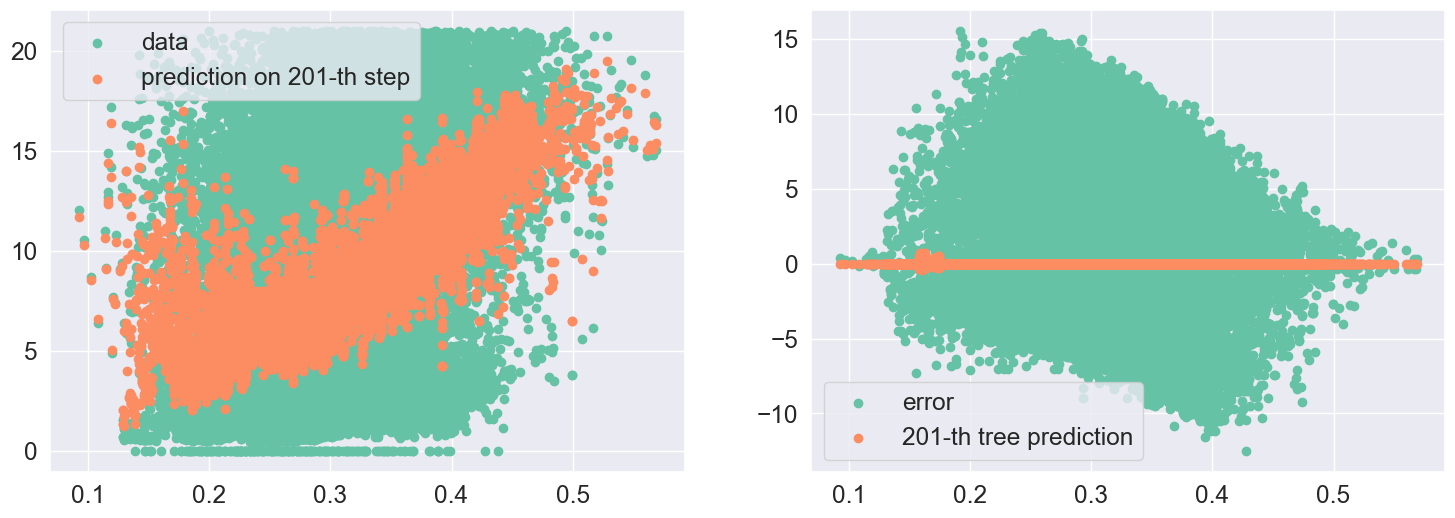

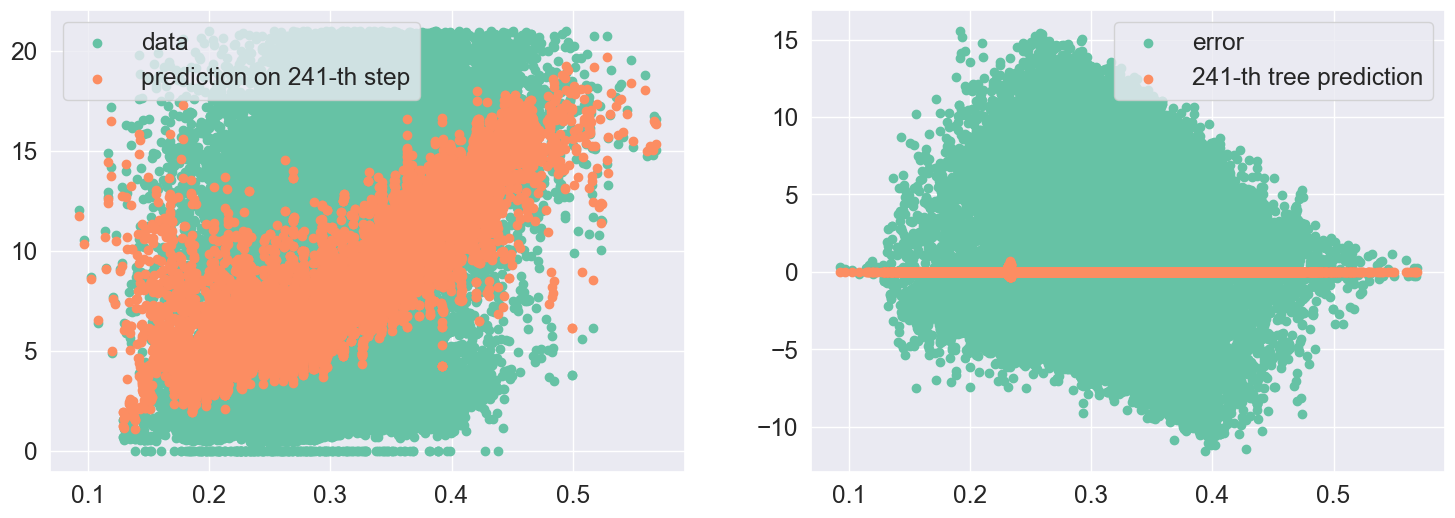

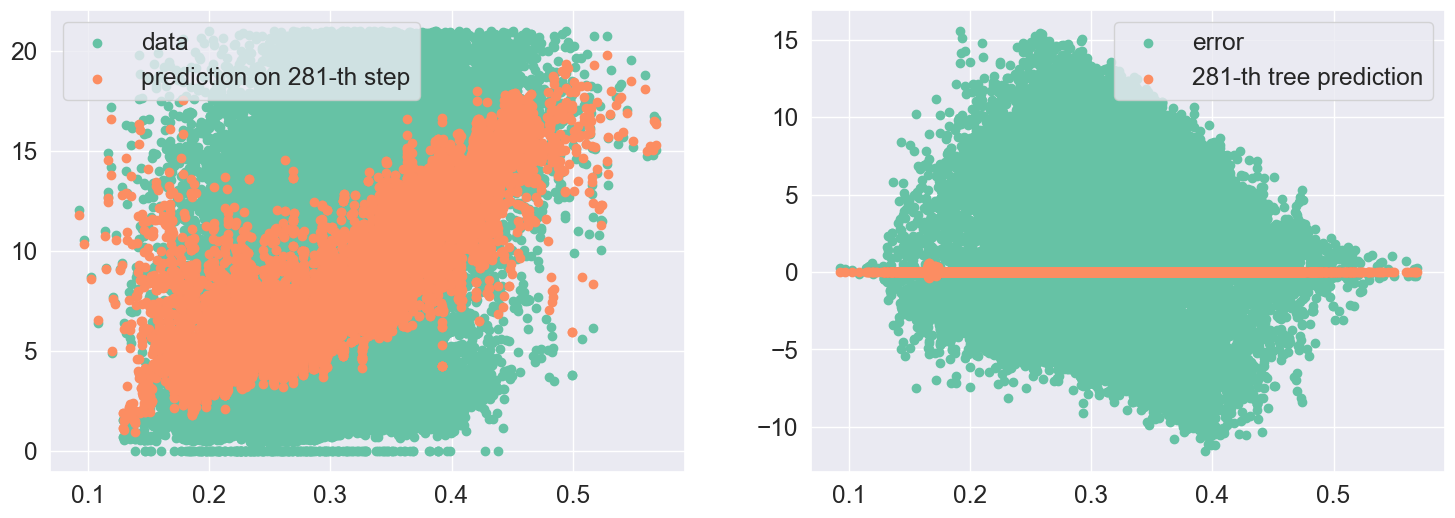

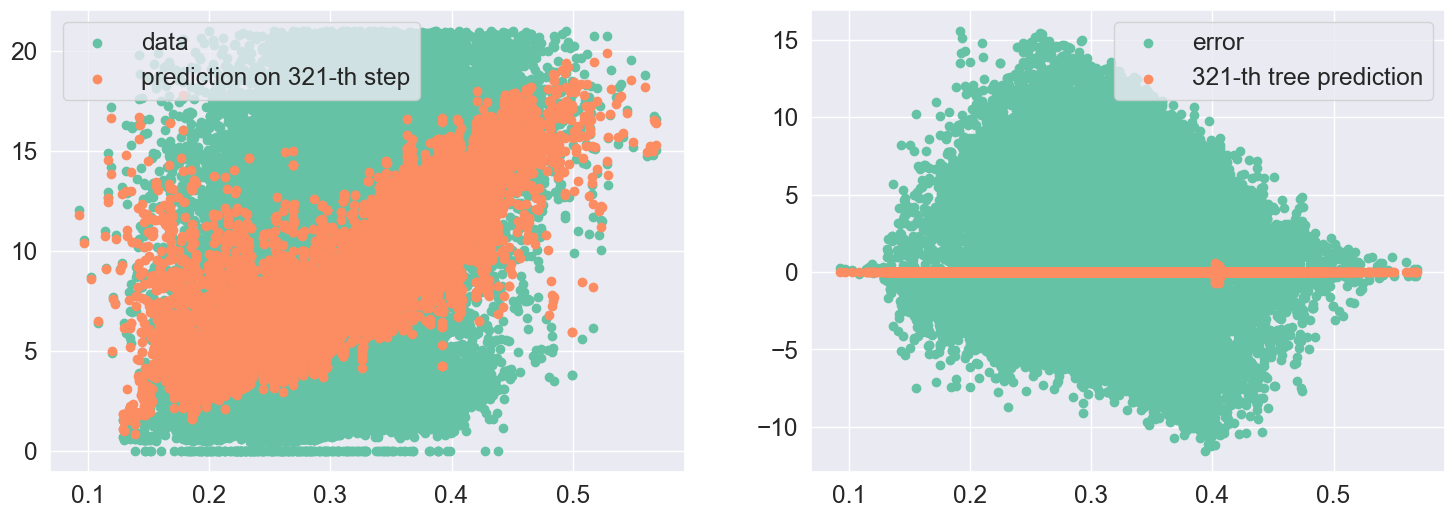

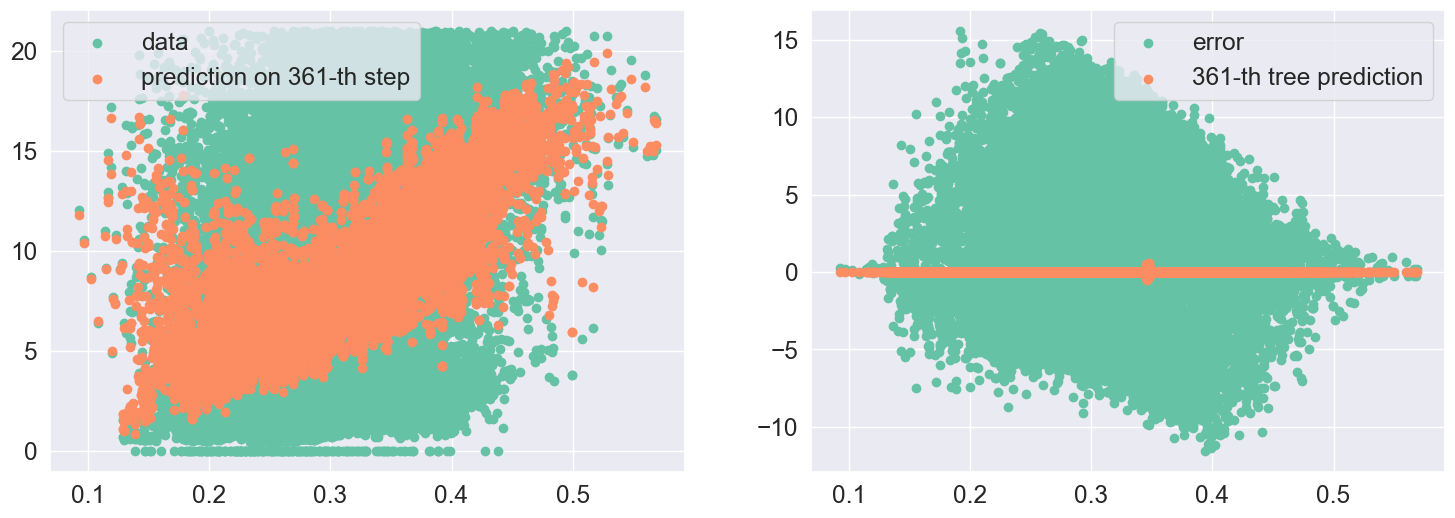

In [52]:
for i in range(1, 401, 40):
    if i == 0:
        previous_predict = np.zeros(len(y_train))
    else:
        previous_predict = staged[i-1]
    error = y_train - previous_predict
    current_step_predict = staged[i] - previous_predict

    fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
    axs[0].scatter(onef_X_train, y_train, label='data')
    axs[0].scatter(onef_X_train, staged[i], label=f'prediction on {i}-th step')
    axs[0].legend()

    axs[1].scatter(onef_X_train, y_train - previous_predict, label='error')
    axs[1].scatter(onef_X_train, current_step_predict, label=f'{i}-th tree prediction')
    axs[1].legend()

**Выводы:**

Теперь все ясно. Предсказания становятся шире, тогда как ошибка, наоборот, сужается к нулю. При этом предсказания каждой следующей модели становятся всё менее значительными.

### Задача 2


Возьмем данные из предыдущего дз.

Исследуйте зависимость качества по метрике MAPE для моделей XGBoost, LightGBM,
CatBoost, а так же градиентного бустинга из sklearn, в зависимости от количества
деревьев, их максимальной глубины, шага обучения, а также различных регуляризаций.  При исследовании одного гиперпараметра рисуйте один график для всех моделей. Тщательно подберите цвета и тип линий так, чтобы картинка была легко читаемой. При проведении исследований не забывайте писать подробные комментарии
и выводы.

*Совет. Изучите ноутбук про данные фреймворки.*


Данные:

**Профиль физика:** <https://www.kaggle.com/datasets/khsamaha/solar-flares-rhessi>. Будем предсказывать длительность солнечных вспышек. Используйте файл с данными до 2018 года.

**Профиль биология:** <https://archive.ics.uci.edu/dataset/1/abalone>. Будем предсказывать возраст моллюсков.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

##### Загрузка и предобработка данных:

**Биология:**

In [53]:
data = pd.read_csv('abalone.data', names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
                                          'Shucked weight', 'Viscera weight', 'Shell weight',
                                          'Rings'])

Закодируйте категориальный признак.

**Комментарий:** В предыдущем домашнем задании мы исключали категориальный признак. Возможно, это опечатка, но я повторю все шаги по предобработке данных так же, как в прошлый раз.

In [54]:
data = data.drop('Sex', axis=1)
X = data.drop('Rings', axis=1)
y = data['Rings'] + 1.5

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
cb_train_data = Pool(
    data=X_train,
    label=y_train,
)

cb_test_data = Pool(
    data=X_test,
)

In [57]:
n_estimators = np.arange(10, 451, 25)

sgb_mape = []
xgb_mape = []
cgb_mape = []
lgb_mape = []

for est in tqdm(n_estimators):
    gb = GradientBoostingRegressor(n_estimators=est, learning_rate=0.1)
    xgb = XGBRegressor(n_estimators=est, learning_rate=0.1)
    cgb = CatBoostRegressor(silent=True, iterations=est, learning_rate=0.1)
    lgb = LGBMRegressor(n_estimators=est, learning_rate=0.1)

    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    cgb.fit(cb_train_data)
    lgb.fit(X_train, y_train)

    sgb_mape.append(mape(y_test, gb.predict(X_test)))
    xgb_mape.append(mape(y_test, xgb.predict(X_test)))
    cgb_mape.append(mape(y_test, cgb.predict(cb_test_data)))
    lgb_mape.append(mape(y_test, lgb.predict(X_test)))

  0%|          | 0/18 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

In [58]:
def plot_mapes(*args, xgrid, xlabel, labels=['Sklearn', 'Xgboost', 'Catboost', 'Lightgbm'], semilog=False):

    plt.figure(figsize=(8, 6))

    for metr, label in zip(args, labels):
        if semilog:
            plt.semilogx(xgrid, metr, label=label)
        else:
            plt.plot(xgrid, metr, label=label)

    plt.legend()
    plt.title('Test MAPE')
    plt.xlabel(xlabel)

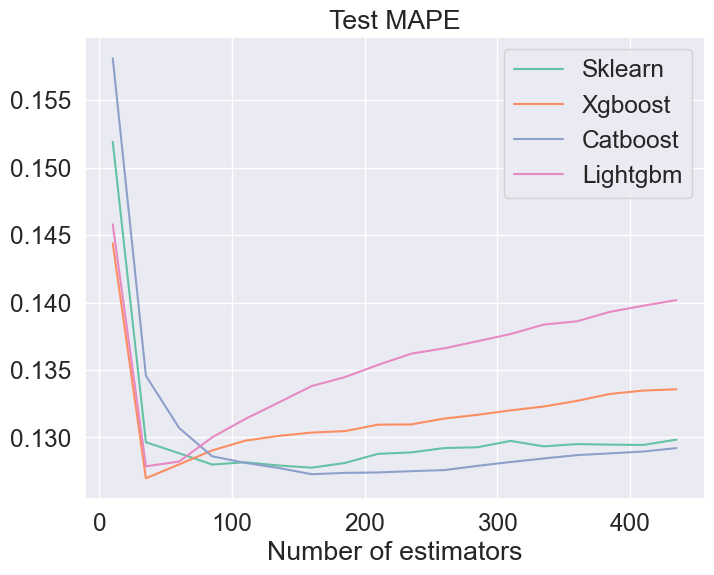

In [59]:
plot_mapes(sgb_mape,
           xgb_mape,
           cgb_mape,
           lgb_mape,
           xlabel='Number of estimators',
           xgrid=n_estimators
          )

**Вывод:**

При заданной скорости обучения (установил всем одинаковое значение 0.1, близкое к дефолтному) видно, что xgboost достигает минимума ошибки "быстрее всех" при меньшем количестве деревьев, но затем начинает быстро переобучаться. LightGBM демонстрирует схожее поведение, но с более высокой ошибкой по сравнению с xgboost. Ошибка бустинга из sklearn снижается достаточно плавно, но примерно после 150 деревьев начинает расти, что также указывает на переобучение. Наиболее стабильно себя проявляет наш отечественный CatBoost: ошибка постепенно уменьшается, и переобучение не наблюдается в рассматриваемом диапазоне. С примерно 200 деревьями CatBoost показывает лучшие результаты.

In [60]:
max_depths = np.arange(2, 12, 1)

sgb_mape = []
xgb_mape = []
cgb_mape = []
lgb_mape = []

for max_depth in tqdm(max_depths):
    gb = GradientBoostingRegressor(max_depth=max_depth, learning_rate=0.1)
    xgb = XGBRegressor(max_depth=max_depth, learning_rate=0.1)
    cgb = CatBoostRegressor(silent=True, max_depth=max_depth, learning_rate=0.1)
    lgb = LGBMRegressor(boosting_type='dart', max_depth=max_depth, learning_rate=0.1)

    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    cgb.fit(cb_train_data)
    lgb.fit(X_train.values, y_train)

    sgb_mape.append(mape(y_test, gb.predict(X_test)))
    xgb_mape.append(mape(y_test, xgb.predict(X_test)))
    cgb_mape.append(mape(y_test, cgb.predict(cb_test_data)))
    lgb_mape.append(mape(y_test, lgb.predict(X_test.values)))

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

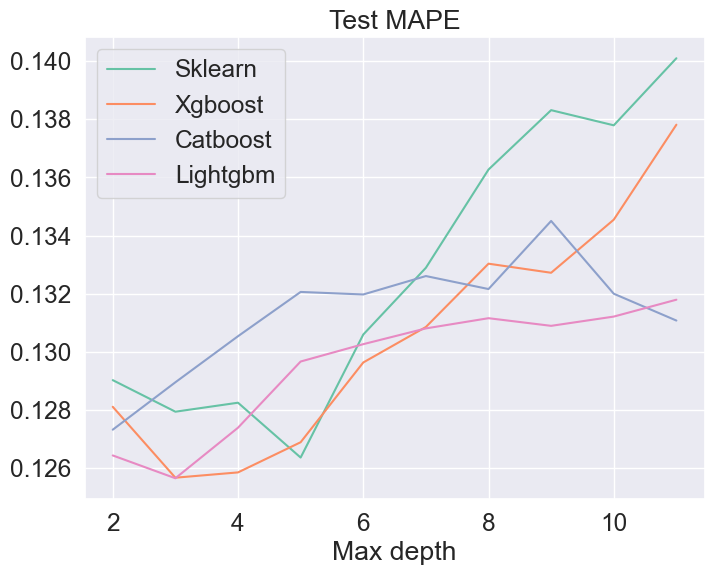

In [61]:
plot_mapes(sgb_mape,
           xgb_mape,
           cgb_mape,
           lgb_mape,
           xlabel='Max depth',
           xgrid=max_depths
          )

**Вывод:**

Для всех моделей наблюдается оптимальное значение при небольшой глубине дерева: для LightGBM это 3, а для остальных моделей — 4. Затем все они начинают переобучаться. При заданной скорости обучения и остальных дефолтных параметрах LightGBM демонстрирует наилучшие результаты.

In [62]:
lrs = np.logspace(-5, 0, 31)

sgb_mape = []
xgb_mape = []
cgb_mape = []
lgb_mape = []

for lr in tqdm(lrs):
    gb = GradientBoostingRegressor(learning_rate=lr)
    xgb = XGBRegressor(learning_rate=lr)
    cgb = CatBoostRegressor(silent=True, learning_rate=lr)
    lgb = LGBMRegressor(boosting_type='dart', learning_rate=lr)

    gb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    cgb.fit(cb_train_data)
    lgb.fit(X_train.values, y_train)

    sgb_mape.append(mape(y_test, gb.predict(X_test)))
    xgb_mape.append(mape(y_test, xgb.predict(X_test)))
    cgb_mape.append(mape(y_test, cgb.predict(cb_test_data)))
    lgb_mape.append(mape(y_test, lgb.predict(X_test.values)))

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start trainin

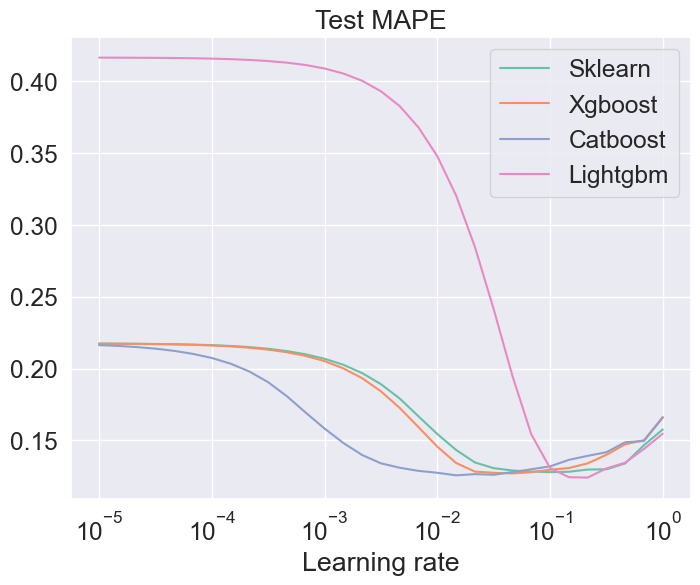

In [63]:
plot_mapes(sgb_mape,
           xgb_mape,
           cgb_mape,
           lgb_mape,
           xlabel='Learning rate',
           xgrid=lrs,
           semilog=True
          )

**Вывод:**

Для всех моделей оптимальные значения находятся при низких значениях learning rate, примерно от 0.01 до 0.2. Метрика быстрее всего снижается у CatBoost, однако после 0.1 начинается переобучение. Похожая ситуация наблюдается и у моделей sklearn и xgboost. LightGBM снижает метрику медленнее всего, достигая минимума около 0.2, но этот минимум является глобальным среди всех представленных моделей.

In [64]:
reg_lambdas = np.linspace(0, 1, 50)

sgb_mape = []
xgb_mape = []
cgb_mape = []
lgb_mape = []

for reg_lambda in tqdm(reg_lambdas):
    xgb = XGBRegressor(reg_lambda=reg_lambda, learning_rate=0.1)
    cgb = CatBoostRegressor(silent=True, reg_lambda=reg_lambda, learning_rate=0.1)
    lgb = LGBMRegressor(boosting_type='dart', reg_lambda=reg_lambda, learning_rate=0.1)

    xgb.fit(X_train, y_train)
    cgb.fit(cb_train_data)
    lgb.fit(X_train.values, y_train)

    xgb_mape.append(mape(y_test, xgb.predict(X_test)))
    cgb_mape.append(mape(y_test, cgb.predict(cb_test_data)))
    lgb_mape.append(mape(y_test, lgb.predict(X_test.values)))

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 7
[LightGBM] [Info] Start training from score 11.438342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 

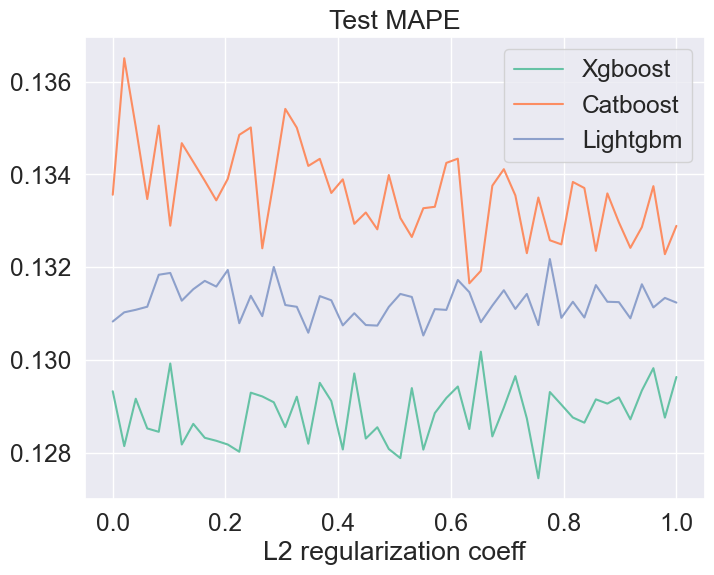

In [65]:
plot_mapes(xgb_mape,
           cgb_mape,
           lgb_mape,
           xlabel='L2 regularization coeff',
           xgrid=reg_lambdas,
           labels=['Xgboost', 'Catboost', 'Lightgbm']
          )

**Вывод:**

По этому графику трудно сделать однозначные выводы. Параметр регуляризации, очевидно, следует подбирать вместе с остальными параметрами с помощью grid search или randomized search. "На глаз" оценить ситуацию практически невозможно.

**Глобальный вывод по задаче:**

Каждый из рассмотренных методов бустинга имеет свои особенности и требует уникального набора оптимальных гиперпараметров. При решении задач машинного обучения важно учитывать это и при выборе фреймворка для бустинга помнить о его характеристиках, а также тщательно подбирать гиперпараметры, которые будут оптимальны для данной задачи в рамках конкретного фреймворка.

Тем не менее, для некоторых гиперпараметров, таких как скорость обучения, можно заметить общие тенденции.